# PERSAMAAN PANAS 2 DIMENSI DENGAN SUMBER PANAS DI PINGGIR DOMAIN

In [1]:
!pip install deepxde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 5.4 MB/s eta 0:00:00


In [2]:
import deepxde as dde
import numpy as np
from deepxde.backend import tf

# library untuk membuat animasi:
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
from matplotlib import cm

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)
Enable just-in-time compilation with XLA.



In [3]:
plt.rcParams['animation.ffmpeg_path'] = r'C:\FFmpeg\bin\ffmpeg.exe'
dde.config.set_default_float("float64")
dde.optimizers.config.set_LBFGS_options(maxiter=15000)

Set the default float type to float64


# PINN

In [4]:
# fungsi untuk menentukan titik yg akan dicari solusinya
def gen_solution_points():
    # jumlah titik tiap dimensi:
    x_dim, y_dim, t_dim = (50, 50, 1000)

    # batas dari x dan t:
    x_min, y_min, t_min = (0, 0, 0.0)
    x_max, y_max, t_max = (L, L, maxtime)

    # titik titik yg akan dicari solusinya:
    t = np.linspace(t_min, t_max, num=t_dim).reshape(t_dim, 1)
    x = np.linspace(x_min, x_max, num=x_dim).reshape(x_dim, 1)
    y = np.linspace(y_min, y_max, num=y_dim).reshape(y_dim, 1)

    # Save:
    np.savez("heat_eq_data", x=x, y=y, t=t)

def gen_testdata():
    # Load data:
    data = np.load("heat_eq_data.npz")
    t, x, y = data["t"], data["x"], data["y"]
    # ratakan data:
    yy, tt, xx = np.meshgrid(y, t, x)
    X = np.vstack((np.ravel(xx), np.ravel(yy), np.ravel(tt))).T
    return X

In [5]:
# Problem parameters:
a = 2.225e-5  # Thermal diffusivity
L = 1  # panjang interval
maxtime = 10000
var = .05
mean = .25

In [6]:
gen_solution_points()

In [7]:
def pde(x, u):
    # persamaan diferensial parsial: persamaan panas 2d dengan sumber panas
    du_xx = dde.grad.hessian(u, x, i=0, j=0)
    du_yy = dde.grad.hessian(u, x, i=1, j=1)
    du_t = dde.grad.jacobian(u, x, i=0, j=2)
    K = 0.00085*1000/63.65
    S = K / (var*var*(2*np.pi)) * tf.exp(-0.5*(((x[:, 0:1]-mean)/var)**2 + ((x[:, 1:2]-mean)/var)**2))
    return du_t - (a * (du_xx + du_yy)) - S

In [8]:
# geometri domain permasalahan
geom = dde.geometry.Rectangle((0,0), (L,L))
timedomain = dde.geometry.TimeDomain(0, maxtime)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

In [9]:
# Initial and boundary conditions:
bc = dde.icbc.DirichletBC(geomtime, lambda x: 25, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime,
    lambda x: 25,
    lambda _, on_initial: on_initial,
                    )


In [10]:
# definisi PDP dan konfigurasi neural network
data = dde.data.TimePDE(
    geomtime,
    pde,
    [bc, ic],
    num_domain=5000,
    num_boundary=400,
    num_initial=200,
    num_test=5000,
)
net = dde.nn.FNN([3] + [32] * 4 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

In [11]:
# definisi layer feature transform
def feature_transform(X):
  return tf.concat([tf.reshape(X[:, 0:1], (-1,1)), tf.reshape(X[:, 1:2], (-1,1)), tf.reshape(X[:, 2:], (-1,1))*1e-3], axis=1)

net.apply_feature_transform(feature_transform)
net.apply_output_transform(lambda x, y: y*100)

In [12]:
# Bangun dan latih model dengan 2 metode optimasi
model.compile("adam", lr=1e-3, loss_weights=[1e3,1e-2,1e-2])
model.train(iterations=10000)
model.compile("L-BFGS", loss_weights=[1e3,1e-2,1e-2])
losshistory, train_state = model.train()

Compiling model...
Building feed-forward neural network...
'build' took 0.256135 s



/usr/local/lib/python3.10/dist-packages/deepxde/nn/tensorflow_compat_v1/fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'compile' took 4.432124 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [5.62e+00, 1.84e+01, 5.22e+01]    [4.89e-01, 1.84e+01, 5.22e+01]    []  
1000      [5.36e+00, 2.92e-03, 2.45e-03]    [1.48e-04, 2.92e-03, 2.45e-03]    []  
2000      [5.35e+00, 3.85e-03, 2.25e-03]    [5.78e-04, 3.85e-03, 2.25e-03]    []  
3000      [5.30e+00, 1.48e-02, 3.38e-03]    [3.66e-03, 1.48e-02, 3.38e-03]    []  
4000      [9.26e-02, 8.53e-03, 9.09e-03]    [2.89e-02, 8.53e-03, 9.09e-03]    []  
5000      [4.16e-02, 4.30e-03, 4.83e-03]    [1.06e-02, 4.30e-03, 4.83e-03]    []  
6000      [2.37e-02, 2.38e-03, 3.43e-03]    [1.44e-02, 2.38e-03, 3.43e-03]    []  
7000      [1.57e-02, 1.20e-03, 1.99e-03]    [2.04e-02, 1.20e-03, 1.99e-03]    []  
8000      [1.09e-02, 1.18e-03, 1.52e-03]    [2.13e-02, 1.18e-03, 1.52e-03]    []  
9000      [7.03e-03, 5.64e-04, 1.12e-03]    [1.75e-02, 5.64e-04, 1.12e-03]    []  
10000     [5.13e-03, 5.75e-04, 9.5

Saving loss history to /content/loss.dat ...
Saving training data to /content/train.dat ...
Saving test data to /content/test.dat ...


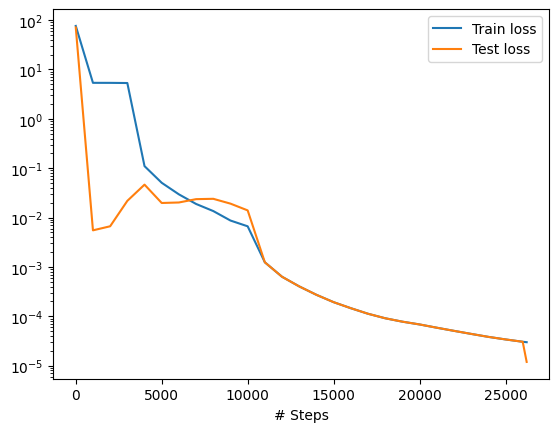

In [13]:
# Plot/print hasil
dde.saveplot(losshistory, train_state, issave=True, isplot=True)
X = gen_testdata()
y_PINN = model.predict(X)
np.savetxt("test.dat", np.hstack((X, y_PINN)))

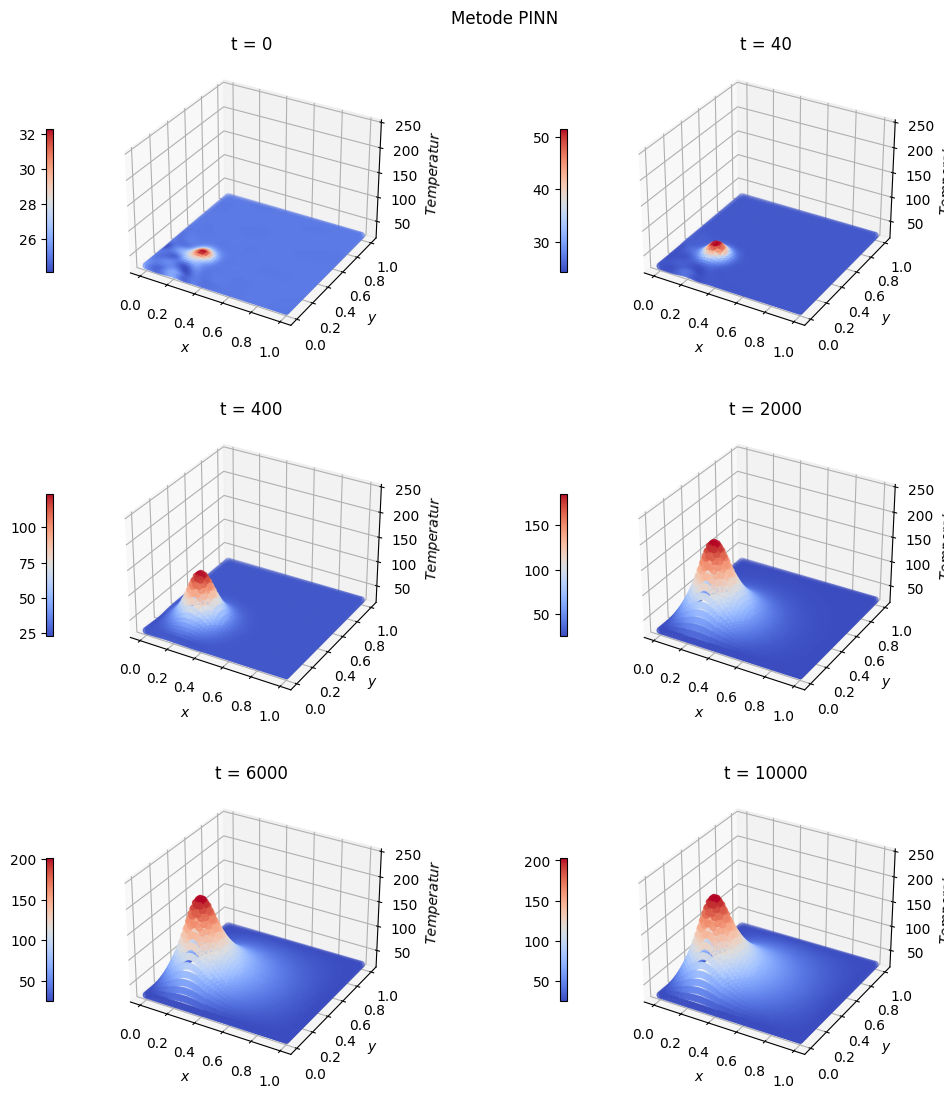

In [14]:
# Plot hasil yang diperoleh
fig = plt.figure(figsize=(11,11))
plt.suptitle("Metode PINN")

ax = fig.add_subplot(3, 2, 1, projection='3d')
surf = ax.scatter(X[2500:5000, 0], X[2500:5000, 1], y_PINN[2500:5000], c=y_PINN[2500:5000], cmap=cm.coolwarm)
ax.set_title("t = {:.0f}".format(X[0, 2]))
ax.set_zlim(20, 250)
# ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 2, projection='3d')
surf = ax.scatter(X[10000:12500, 0], X[10000:12500, 1], y_PINN[10000:12500], c=y_PINN[10000:12500], cmap=cm.coolwarm)
ax.set_title("t = {:.0f}".format(X[10000, 2]))
ax.set_zlim(20, 250)
# ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 3, projection='3d')
surf = ax.scatter(X[100000:102500, 0], X[100000:102500, 1], y_PINN[100000:102500], c=y_PINN[100000:102500], cmap=cm.coolwarm)
ax.set_title(" \n \nt = {:.0f}".format(X[100000, 2]))
ax.set_zlim(20, 250)
# ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 4, projection='3d')
surf = ax.scatter(X[500000:502500, 0], X[500000:502500, 1], y_PINN[500000:502500], c=y_PINN[500000:502500], cmap=cm.coolwarm)
ax.set_title(" \n \nt = 2000")#{:.0f}".format(X[500000, 2]))
ax.set_zlim(20, 250)
# ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 5, projection='3d')
surf = ax.scatter(X[1497500:1500000, 0], X[1497500:1500000, 1], y_PINN[1497500:1500000], c=y_PINN[1497500:1500000], cmap=cm.coolwarm)
ax.set_title(" \n \nt = 6000")#:.0f}".format(X[1497500, 2]))
ax.set_zlim(20, 250)
# ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

ax = fig.add_subplot(3, 2, 6, projection='3d')
surf = ax.scatter(X[2497500:2500000, 0], X[2497500:2500000, 1], y_PINN[2497500:2500000], c=y_PINN[2497500:2500000], cmap=cm.coolwarm)
ax.set_title(" \n \nt = {:.0f}".format(X[2497500, 2]))
ax.set_zlim(20, 250)
# ax.set_zlim(-0.1, 1)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$Temperatur$')
fig.colorbar(surf, shrink=.5, location='left')

plt.tight_layout()
plt.savefig("PINN2dhsvar2.png", dpi=300)

# Plot perkembangan temperatur terhadap waktu

In [15]:
idx1 = np.where(np.isclose(X[:, 0], 0) & (np.isclose(X[:, 0], X[:, 1])))[0]
idx2 = np.where((X[:, 0] >= 0.07) & (X[:, 0] <= 0.09) & (np.isclose(X[:, 0], X[:, 1])))[0]
idx3 = np.where((X[:, 0] >= 0.17) & (X[:, 0] <= 0.19) & (np.isclose(X[:, 0], X[:, 1])))[0]
idx4 = np.where((X[:, 0] >= 0.27) & (X[:, 0] <= 0.29) & (np.isclose(X[:, 0], X[:, 1])))[0]
idx5 = np.where((X[:, 0] >= 0.37) & (X[:, 0] <= 0.39) & (np.isclose(X[:, 0], X[:, 1])))[0]
idx6 = np.where((X[:, 0] >= 0.47) & (X[:, 0] <= 0.49) & (np.isclose(X[:, 0], X[:, 1])))[0]

In [16]:
result1 = X[idx1]
result2 = X[idx2]
result3 = X[idx3]
result4 = X[idx4]
result5 = X[idx5]
result6 = X[idx6]

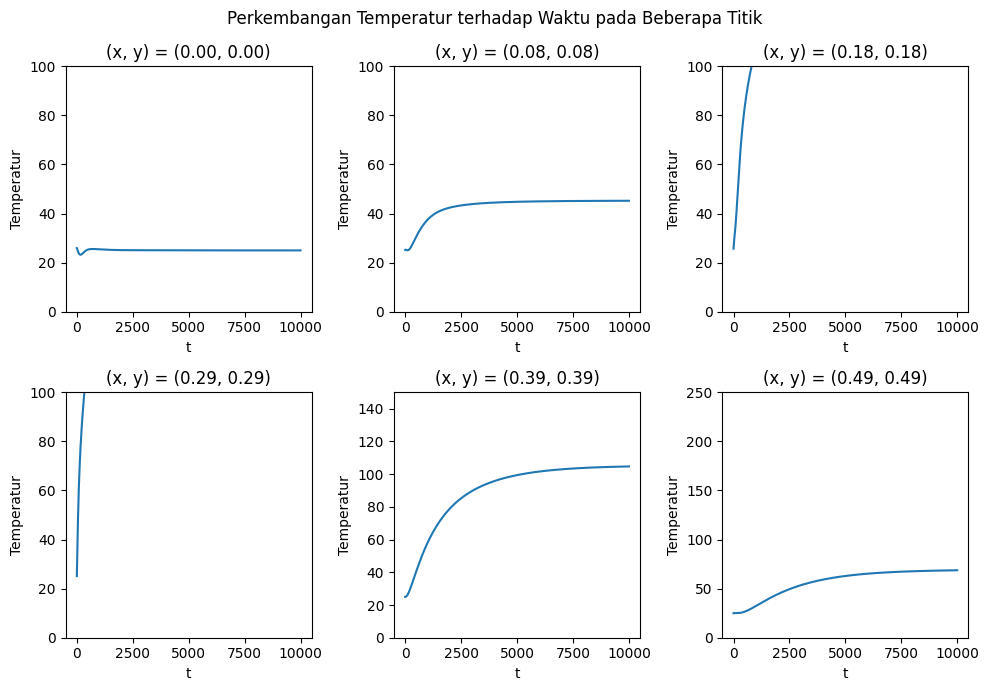

In [17]:
fig = plt.figure(figsize=(10,7))
plt.suptitle("Perkembangan Temperatur terhadap Waktu pada Beberapa Titik")

ax = fig.add_subplot(2, 3, 1)
ax.set_ylabel("Temperatur")
ax.set_xlabel("t")
ax.plot(result1[:, 2], y_PINN[idx1])
plt.title("(x, y) = ({:.2f}, {:.2f})".format(result1[0, 1], result1[0, 1]))
plt.ylim((0,100))

ax = fig.add_subplot(2, 3, 2)
ax.set_ylabel("Temperatur")
ax.set_xlabel("t")
ax.plot(result2[:, 2], y_PINN[idx2])
plt.title("(x, y) = ({:.2f}, {:.2f})".format(result2[0, 1], result2[0, 1]))
plt.ylim((0,100))

ax = fig.add_subplot(2, 3, 3)
ax.set_ylabel("Temperatur")
ax.set_xlabel("t")
ax.plot(result3[:, 2], y_PINN[idx3])
plt.title("(x, y) = ({:.2f}, {:.2f})".format(result3[0, 1], result3[0, 1]))
plt.ylim((0,100))

ax = fig.add_subplot(2, 3, 4)
ax.set_ylabel("Temperatur")
ax.set_xlabel("t")
ax.plot(result4[:, 2], y_PINN[idx4])
plt.title("(x, y) = ({:.2f}, {:.2f})".format(result4[0, 1], result4[0, 1]))
plt.ylim((0,100))

ax = fig.add_subplot(2, 3, 5)
ax.set_ylabel("Temperatur")
ax.set_xlabel("t")
ax.plot(result5[:, 2], y_PINN[idx5])
plt.title("(x, y) = ({:.2f}, {:.2f})".format(result5[0, 1], result5[0, 1]))
plt.ylim((0,150))

ax = fig.add_subplot(2, 3, 6)
ax.set_ylabel("Temperatur")
ax.set_xlabel("t")
ax.plot(result6[:, 2], y_PINN[idx6])
plt.title("(x, y) = ({:.2f}, {:.2f})".format(result6[0, 1], result6[0, 1]))
plt.ylim((0,250))

plt.tight_layout()
plt.savefig("PINN2dhstimevar2.png", dpi=300)

# Animation

In [18]:
# Animasi hasil
result = np.hstack((X, y_PINN))
time = np.unique(result[:, 2])

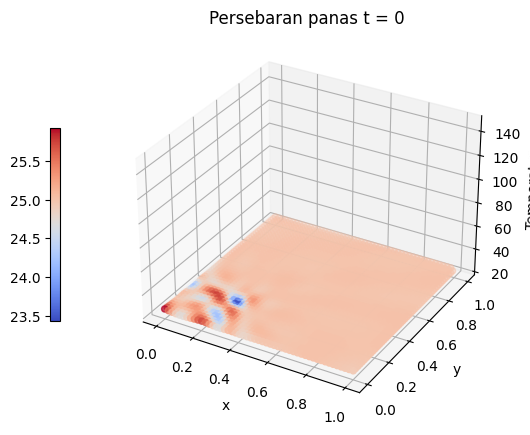

In [19]:
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1, 1, 1, projection='3d')

def update(frame):
    ax.clear()
    ax.set_title(" ")
    ax.set_zlim([20, 150])
    ax.set_zlabel("Temperatur")
    ax.set_ylabel("y")
    ax.set_xlabel("x")
    ax.grid()
    a = np.where(result[:, 2] == time[frame])[0][0]
    b = np.where(result[:, 2] == time[frame])[0][-1]
    surface = ax.scatter(result[a:b, 0], result[a:b, 1], result[a:b, 3], c=result[a:b, 3], cmap=cm.coolwarm)
    ax.set_title("Persebaran panas t = {:.0f}".format(result[a, 2]))
    fig.colorbar(surface, ax=ax, shrink=.5, location='left')

ani = FuncAnimation(fig, update, frames=int(len(time)))

In [20]:
# Save animasi sebagai video
# ani.save("heat eq 2dhsvar2.mp4", bitrate=6000, dpi=200, fps=30)

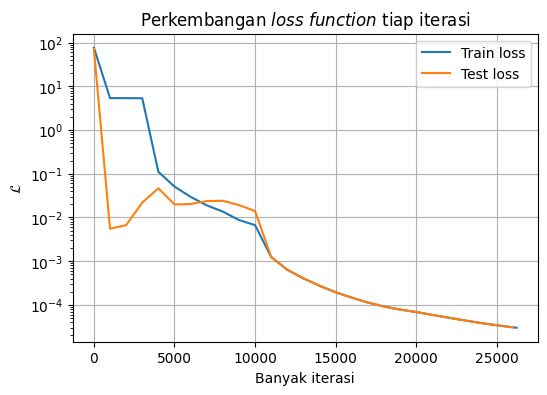

In [21]:
# simpan plot loss history
loss_train = np.sum(losshistory.loss_train, axis=1)
loss_test = np.sum(losshistory.loss_test, axis=1)

plt.figure(figsize=(6,4))
plt.grid()
plt.title("Perkembangan $loss$ $function$ tiap iterasi")
plt.semilogy(losshistory.steps, loss_train, label="Train loss")
plt.semilogy(losshistory.steps[:-1], loss_test[:-1], label="Test loss")
for i in range(len(losshistory.metrics_test[0])):
    plt.semilogy(
        loss_history.steps,
        np.array(loss_history.metrics_test)[:, i],
        label="Test metric",
    )
plt.xlabel("Banyak iterasi")
plt.ylabel("$\mathcal{L}$")
plt.legend()
plt.savefig('loss.png', dpi=300)